In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.lines import Line2D
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 14
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
from analysis.utils import *

%load_ext autoreload
%autoreload 2

model_list = ['e_coli_core', 'iECW_1372', 'iIT341', 'iJO1366', 'iML1515', 'iNJ661', 'iPC815', 'iSSON_1240', 'iYL1228', 'iYS1720', 'STM_v1_0']

In [11]:
df_list = []
verbosity = 0
df_grouped_list = []
df_grouped_net = pd.DataFrame()

for model in model_list:
    print("PSL/RSL analysis for Model", model, "... ", end="")

    # Obtain pFBA class of the reaction pair
    df_pFBA = pd.read_csv("../results/" + model + "/" + model + "_pFBA.csv")
    
    # Get the flux distributions
    df_FVA = pd.read_csv("../results/" + model + "/" + model + "_FVA_one_norm_100.csv")
    
    # Combine the results into one dataframe
    df_FVA = combine_results(df_pFBA, df_FVA)

    # Perform PSL/RSL segregation
    df_FVA = psl_rsl(df_FVA, model)
    
    # display(df_FVA)
    df_list.append(df_FVA)
    df_FVA.to_csv("../results/" + model + "/" + model + "_PSL_RSL_one_norm_100.csv")

    # Get the distribution of the reaction pairs
    df_grouped = get_distribution(df_FVA, model)
    df_grouped_list.append(df_grouped)
    df_grouped["Organism"] = model
    df_grouped_net = df_grouped_net.append(df_grouped)
    
    # count_list.append(count)
    # fraction_list.append(fraction)
    
    print("Done!")
    # display(df_FVA)
        
        
    if verbosity: 
        print("Distribution:")
        print(df_grouped)
        print("="*50)

count_list, fraction_list = plot_results(df_grouped_net, model_list)

PSL/RSL analysis for Model e_coli_core ... Done!
PSL/RSL analysis for Model iECW_1372 ... Done!
PSL/RSL analysis for Model iIT341 ... Done!
PSL/RSL analysis for Model iJO1366 ... Done!
PSL/RSL analysis for Model iML1515 ... Done!
PSL/RSL analysis for Model iNJ661 ... Done!
PSL/RSL analysis for Model iPC815 ... Done!
PSL/RSL analysis for Model iSSON_1240 ... Done!
PSL/RSL analysis for Model iYL1228 ... Done!
PSL/RSL analysis for Model iYS1720 ... Done!
PSL/RSL analysis for Model STM_v1_0 ... Done!


In [3]:
# count_list, fraction_list
psl_list = []
psl_frac_list = []
rsl_list = []
rsl_frac_list = []
for count, fraction, model in zip(count_list, fraction_list, model_list):
    psl_list.append(count["PSL"])
    psl_frac_list.append(fraction["PSL"])
    rsl_list.append(count["RSL"])
    rsl_frac_list.append(fraction["RSL"])
    
temp = pd.DataFrame({"Model":model_list, "PSL Count": psl_list, "RSL Count": rsl_list})
temp["PSL Fraction"] = psl_frac_list
temp["RSL Fraction"] = rsl_frac_list
temp.to_csv("../results/csv/overall_psl_rsl.csv")
temp

,Model,PSL Count,RSL Count,PSL Fraction,RSL Fraction
0,e_coli_core,16,72,0.181818,0.818182
1,iECW_1372,241,25,0.906015,0.093985
2,iIT341,39,15,0.722222,0.277778
3,iJO1366,243,25,0.906716,0.093284
4,iML1515,251,35,0.877622,0.122378
5,iNJ661,60,15,0.800000,0.200000
6,iPC815,172,17,0.910053,0.089947
7,iSSON_1240,239,28,0.895131,0.104869
8,iYL1228,119,25,0.826389,0.173611
9,iYS1720,272,58,0.824242,0.175758


In [4]:
# Get a stacked bar graph of the distribution of the 
# snythetic lethal pairs across models.
x = model_list
count_array = np.array(count_list)
fraction_array = np.array(fraction_list)

# Use textposition='auto' for direct text
fig = go.Figure(data=[
    go.Bar(name="PSL", x=model_list, y=fraction_array[:,0]),
    go.Bar(name="RSL", x=model_list, y=fraction_array[:,1])
])
# Change the bar mode
fig.update_layout(barmode='stack', \
                  title="Distribution of PSL and RSL reactions",\
                  xaxis_title="Organisms", \
                  yaxis_title="Fraction of Reactions")
fig.write_image("../results/images/psl_rsl_dist.pdf")
fig.show()

In [5]:
psl_counts = {}

for df, model in zip(df_list, model_list):
    df["Rxn_1_Active"] = np.abs(df["Rxn_1_Min"]) > 0
    df["Rxn_2_Active"] = np.abs(df["Rxn_2_Min"]) > 0
    psl_df = df.loc[df["Type"]=="PSL",:]
    
    rxn1_mask = (psl_df["Rxn_1_Active"] == True)
    rxn2_mask = (psl_df["Rxn_2_Active"] == True)
    
    psl_df["Active_Reaction"] = np.select([rxn1_mask, rxn2_mask], [psl_df["Rxn_1"], psl_df["Rxn_2"]], default=np.nan)    
    grouped_psl = psl_df.groupby(["Active_Reaction"])["Active_Reaction"].count()
        
    psl_counts[model] = list(grouped_psl)

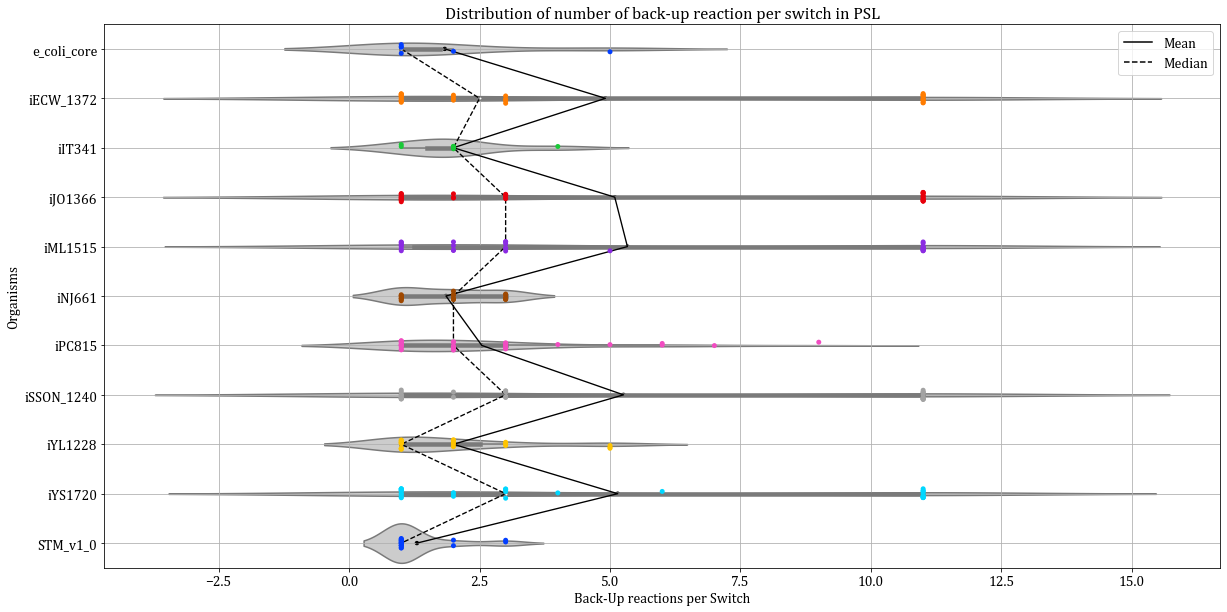

,Count
Organism,
STM_v1_0,1.300000
e_coli_core,1.833333
iECW_1372,4.911765
iIT341,2.000000
iJO1366,5.090909
iML1515,5.333333
iNJ661,1.857143
iPC815,2.542857
iSSON_1240,5.258065


,Count
Organism,
STM_v1_0,1.0
e_coli_core,1.0
iECW_1372,2.5
iIT341,2.0
iJO1366,3.0
iML1515,3.0
iNJ661,2.0
iPC815,2.0
iSSON_1240,3.0


In [6]:
import seaborn as sns

line1 = Line2D([0], [0], label='Mean', color='k')
line2 = Line2D([0], [0], label='Median', color='k', ls="--")

model_value = []
count_value = []

for i in psl_counts:
    for j in psl_counts[i]:
        model_value.append(i)
        count_value.append(j)
        
counts_df = pd.DataFrame({"Organism": model_value, "Count": count_value})

means = list(counts_df.groupby("Organism").mean()["Count"])

col = "Count"
plt.figure(figsize=(20,10))
ax = sns.violinplot(x=col, y="Organism", data=counts_df, color="0.8")
                    # palette=sns.color_palette("bright"), 
ax = sns.stripplot(x=col, y="Organism", data=counts_df, 
                palette=sns.color_palette("bright"), jitter=True)

ax = sns.pointplot(x=col, y='Organism', ci=None, data=counts_df, 
                color="k", estimator=np.mean, label="mean", scale=0.5) 
ax = sns.pointplot(x=col, y='Organism', ci=None, data=counts_df, color="k", 
                linestyles='--', estimator=np.median, label="mean", scale=0.5) 

plt.grid()
ax.set_title("Distribution of number of back-up reaction per switch in PSL")
ax.set_ylabel("Organisms")
ax.set_xlabel("Back-Up reactions per Switch")
plt.legend(handles=[line1, line2])
plt.savefig("../results/images/psl_violin_backup_per_switch.png")
plt.show()

display(counts_df[[col, "Organism"]].groupby("Organism").mean())
display(counts_df[[col, "Organism"]].groupby("Organism").median())

In [7]:
import pandas as pd
from scipy.io import loadmat

essential = []
pfba_opt = []
mle = []
ele = []
zero_flux = []
blocked = []

for model in model_list:
    mat = loadmat("../results/" + model + "/pfba/RxnClasses.mat")
    essential.append(mat["RxnClasses"][0][0][0].size)
    pfba_opt.append(mat["RxnClasses"][0][0][1].size)
    ele.append(mat["RxnClasses"][0][0][2].size)
    mle.append(mat["RxnClasses"][0][0][3].size)
    zero_flux.append(mat["RxnClasses"][0][0][4].size)
    blocked.append(mat["RxnClasses"][0][0][5].size)
    
df = pd.DataFrame()
df["Model"] = model_list
df["Essential"] = essential
df["pFBA"] = pfba_opt
df["ELE"] = ele
df["MLE"] = mle
df["zero"] = zero_flux
df["blocked"] = blocked
df["Total"] = df["Essential"] + df["pFBA"] + df["ELE"] + df["MLE"] + df["zero"] + df["blocked"]

df["Essential Percent"] = df["Essential"]/df["Total"]
df["pFBA Percent"] = df["pFBA"]/df["Total"]
df["ELE Percent"] = df["ELE"]/df["Total"]
df["MLE Percent"] = df["MLE"]/df["Total"]
df["zero Percent"] = df["zero"]/df["Total"]
df["blocked Percent"] = df["blocked"]/df["Total"]
df

,Model,Essential,pFBA,ELE,MLE,zero,blocked,Total,Essential Percent,pFBA Percent,ELE Percent,MLE Percent,zero Percent,blocked Percent
0,e_coli_core,18,30,2,38,8,0,96,0.187500,0.312500,0.020833,0.395833,0.083333,0.000000
1,iECW_1372,287,31,1499,131,737,379,3064,0.093668,0.010117,0.489230,0.042755,0.240535,0.123695
2,iIT341,265,60,21,91,66,53,556,0.476619,0.107914,0.037770,0.163669,0.118705,0.095324
3,iJO1366,289,31,1513,151,657,226,2867,0.100802,0.010813,0.527729,0.052668,0.229159,0.078828
4,iML1515,271,174,76,1222,709,260,2712,0.099926,0.064159,0.028024,0.450590,0.261431,0.095870
5,iNJ661,314,116,69,242,59,226,1026,0.306043,0.113060,0.067251,0.235867,0.057505,0.220273
6,iPC815,216,139,560,152,311,585,1963,0.110036,0.070810,0.285278,0.077433,0.158431,0.298013
7,iSSON_1240,282,32,1443,118,630,465,2970,0.094949,0.010774,0.485859,0.039731,0.212121,0.156566
8,iYL1228,203,145,64,816,533,506,2267,0.089546,0.063961,0.028231,0.359947,0.235112,0.223202
9,iYS1720,262,32,2215,120,650,335,3614,0.072496,0.008854,0.612894,0.033204,0.179856,0.092695


In [8]:
temp = pd.read_csv("../results/csv/overall_psl_rsl.csv", index_col=0)
temp

,Model,PSL Count,RSL Count,PSL Fraction,RSL Fraction
0,e_coli_core,16,72,0.181818,0.818182
1,iECW_1372,241,25,0.906015,0.093985
2,iIT341,39,15,0.722222,0.277778
3,iJO1366,243,25,0.906716,0.093284
4,iML1515,251,35,0.877622,0.122378
5,iNJ661,60,15,0.800000,0.200000
6,iPC815,172,17,0.910053,0.089947
7,iSSON_1240,239,28,0.895131,0.104869
8,iYL1228,119,25,0.826389,0.173611
9,iYS1720,272,58,0.824242,0.175758


In [9]:
temp_new = pd.DataFrame()
psl_or_rsl = []
psl_rsl_values = []
temp_model_list = []

for i in range(temp.shape[0]):
    psl_or_rsl.extend(["PSL", "RSL"])
    
for i in range(temp.shape[0]):
    psl_rsl_values.append(temp.loc[i]["PSL Count"])
    psl_rsl_values.append(temp.loc[i]["RSL Count"])

for i in range(temp.shape[0]):
    temp_model_list.append(temp.loc[i]["Model"])
    temp_model_list.append(temp.loc[i]["Model"])
    
temp_new["Model"] = temp_model_list
temp_new["Type"] = psl_or_rsl
temp_new["Count"] = psl_rsl_values
temp_new.to_csv("../results/csv/overall_R_psl_rsl.csv")

In [10]:
temp_new

,Model,Type,Count
0,e_coli_core,PSL,16
1,e_coli_core,RSL,72
2,iECW_1372,PSL,241
3,iECW_1372,RSL,25
4,iIT341,PSL,39
5,iIT341,RSL,15
6,iJO1366,PSL,243
7,iJO1366,RSL,25
8,iML1515,PSL,251
9,iML1515,RSL,35
